# QC Mentorship program Screening Task #2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

>_Note: I am going to use [Qiskit](https://qiskit.org/) as the Quantum Development Framework_

## First Exercise
Build the following simple circuit to prepare the Bell state:
<p>
<img src="task2-circuit.png">
</p>

**Code:**

In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit import execute, Aer
from qiskit.extensions import UnitaryGate
# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')
stateVectorSimulator = Aer.get_backend('statevector_simulator')


In [5]:
def createBaseCircuit() -> QuantumCircuit:
    # Create 2 qbits circuit
    circuit = QuantumCircuit(2)
    # By default circuit start with |0>, but we can also explicitely reset it with |0> state
    circuit.reset(0)
    circuit.reset(1)
    # Add a H gate on qubit 0
    circuit.h(0)
    # Add a CX (CNOT) gate on control qubit 0 and target qubit 1
    circuit.cx(0, 1)
    return circuit

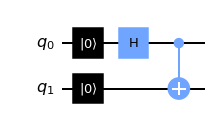

In [6]:
# Draw the circuit
circuitExerciseOne = createBaseCircuit()
circuitExerciseOne.draw('mpl')

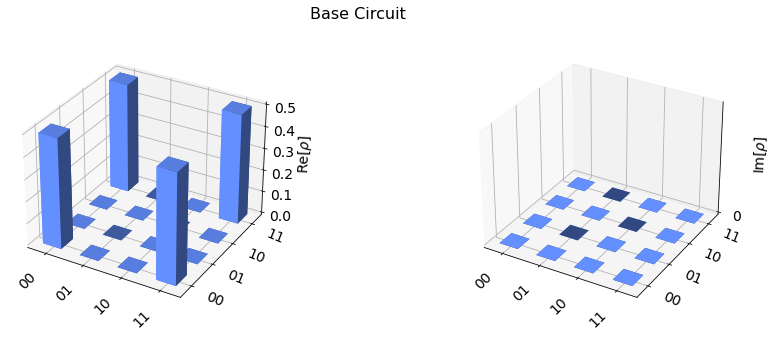

In [7]:
# Print State Vector from Exercise one circuit: NO error and previous to measurement
statevectorExerciseOne = execute(circuitExerciseOne, backend=stateVectorSimulator).result().get_statevector(circuitExerciseOne)
plot_state_city(statevectorExerciseOne, title='Base Circuit')

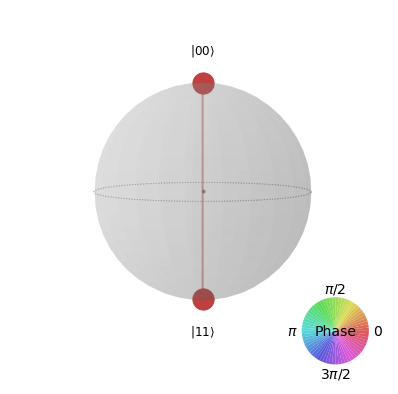

In [8]:
plot_state_qsphere(Statevector.from_instruction(circuitExerciseOne))

### Result Analysis

With the plot state city and from the Bloch Sphere from `Base Circuit` we show that the possible state vectors from that circuit are the Bell states.

## Second Exercise

Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

In [9]:
def initTwoRandomBits() -> str: 
    """ Creates a random two-bit sequence by the resulting of a one-time execution of a 
        two qubit Quantum Circuit with a Hadamard Gate on each one and performing a Z-measurement.
    """
    # Create 2 qbits circuit with 2 classical registers
    internalCircuit = QuantumCircuit(2,2)
    # Adding Hadamard gates on each qubit
    internalCircuit.h(0)
    internalCircuit.h(1)
    # Map the quantum measurement to the classical bits
    internalCircuit.measure([0,1], [0,1])
    # Execute the circuit on the qasm simulator or just ONE execution
    resultOneExecution = execute(internalCircuit, simulator, shots=1).result()
    # Grab the result in dictionary format
    counts = resultOneExecution.get_counts(internalCircuit)
    # Return the two bit string
    return list(counts.keys())[0]

In [10]:
def randomErrorGate() -> UnitaryGate:
    """ 
        Creates an Unitary Gate, either the identity, X or Z gate with a random probability.
        The probability is computed measuring from a new internal two-qubit circuit qubits, 
        to which it has applied a Hadamard gate to in a superposition state and then to 
        generate an actual random probability. 
        Each qubit is then measured with a Z-measurement and the applied final gate to 
        the input circuit is based on the following output decision table:

        q0 q1 final gate
        -- -- ----------
         0  0  Identity
         0  1  X (bit-flip error)
         1  0  Z (sign-flip error)
         1  1  Identity

         The probability decision table gives a 50% of being the Identity, and a 25% the
         X or the Z gate
    """
    from qiskit.circuit.library import IGate, XGate, ZGate

    twoRandomBits = initTwoRandomBits()
    if (twoRandomBits == "00" or twoRandomBits == "11"):
        return UnitaryGate(IGate(), label="Error Gate (I)")
    if (twoRandomBits == "01"):
        return UnitaryGate(XGate(), label="Error Gate (X)")
    if (twoRandomBits == "10"):
        return UnitaryGate(ZGate(), label="Error Gate (Z)")
    

In [11]:
def createBaseCircuitWithErrorGates() -> QuantumCircuit:
    # Create 2 qbits circuit
    qreg_q = QuantumRegister(2, 'q')
    circuit = QuantumCircuit(qreg_q)
    # By default circuit start with |0>, but we can also explicitely reset it with |0> state
    circuit.reset(0)
    circuit.reset(1)
    # Add a H gate on qubit 0
    circuit.h(0)
    # Add an error gate on each qubit
    circuit.append(randomErrorGate(), [qreg_q[0]])
    circuit.append(randomErrorGate(), [qreg_q[1]])
    # Add a CX (CNOT) gate on control qubit 0 and target qubit 1
    circuit.cx(0, 1)
    return circuit

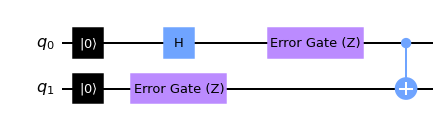

In [12]:
# Draw the circuit
circuitExerciseTwo = createBaseCircuitWithErrorGates()
circuitExerciseTwo.draw('mpl')

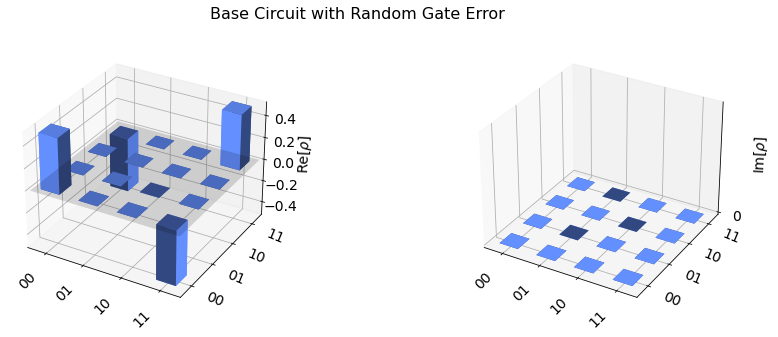

In [13]:
# Print State Vector from Exercise two circuit: WITH error and previous to measurement
statevectorExerciseTwo = execute(circuitExerciseTwo, backend=stateVectorSimulator).result().get_statevector(circuitExerciseTwo)
plot_state_city(statevectorExerciseTwo, title='Base Circuit with Random Gate Error')

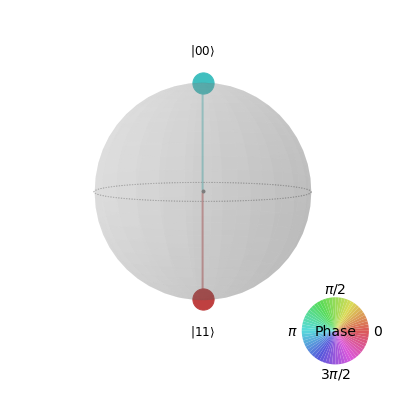

In [14]:
plot_state_qsphere(Statevector.from_instruction(circuitExerciseTwo))

### Result Analysis

With the plot state city and from the Bloch Sphere from `Base Circuit with Random Gate Error` we show that the circuit has altered the Bell State expected output and differs from previous results.
> Note: we have selected one gate that do introduce error. As the gate creation are random, we might encounter some new gates that do not alter the Bell State.

## Third Exercise

Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that **all the possible** choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

### Proposed solution

To solve this part, I am going to use `The Shor code` to fix a possible phase & bit-flip error for a single qubit. To do so, I am codifying the `Shor code` circuit into a unitary operator, so then, I can plug it directly to the final circuit and make it easier to read.
Keep in mind that for a single

In [15]:
def globalErrorGateCircuit() -> QuantumCircuit:
    """ set a 9-qubit circuit with a random Error Gate applied to the first qubit """
    errorCircuit = QuantumCircuit(9, name='  Error(Phi) ')
    errorCircuit.append(randomErrorGate(), [0])
    return errorCircuit

In [16]:
def shorCodeCircuitWithRandomErrorGate() -> QuantumCircuit:
    """  set a 9-qbuit circuit implementing the Shor Code that fixes both bit-flip and sign-flip errors.
         The Shor code can correct arbitrary 1-qubit error, which will be always applied to the phi0 qubit
         with the random error gate, created on the previous exercise. """
    shorCode = QuantumCircuit(9, name='Shor code with Error gate')
    shorCode.cx(0, 3)
    shorCode.cx(0, 6)
    shorCode.h(0)
    shorCode.h(3)
    shorCode.h(6)
    shorCode.cx(0, 1)
    shorCode.cx(0, 2)
    shorCode.cx(3, 4)
    shorCode.cx(3, 5)
    shorCode.cx(6, 7)
    shorCode.cx(6, 8)
    shorCode.append(globalErrorGateCircuit(), range(9))
    shorCode.cx(0, 1)
    shorCode.cx(0, 2)
    shorCode.cx(3, 4)
    shorCode.cx(3, 5)
    shorCode.cx(6, 7)
    shorCode.cx(6, 8)
    shorCode.ccx(2,1,0)
    shorCode.ccx(5,4,3)
    shorCode.ccx(8,7,6)
    shorCode.h(0)
    shorCode.h(3)
    shorCode.h(6)
    shorCode.cx(0, 3)
    shorCode.cx(0, 6)
    shorCode.ccx(6,3,0)

    return shorCode

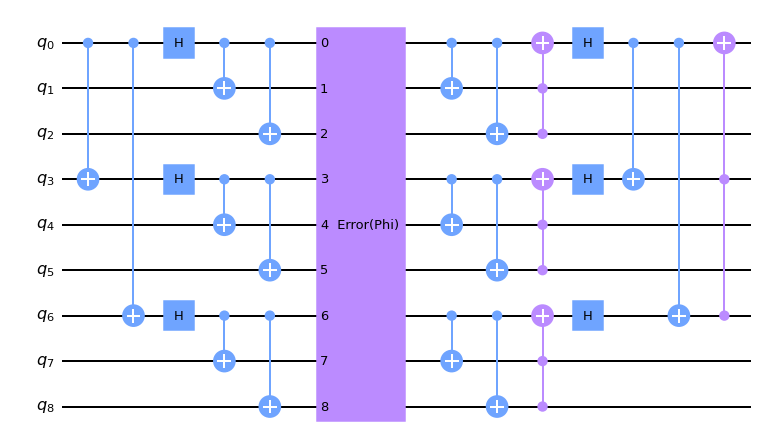

In [17]:
# Printing the Shor code circuit with a random Error Gate
shorCodeCircuitWithRandomErrorGate().draw('mpl')

### Writing the final circuit 

The circuit acts on the 2 logical qubits (`phi` and `psi`), which for each one we add 8 additional qubits that implement the Shor code to correct both bit-flip and sign-flip, resulting into a 18 qubit circuit. The initial circuit gates (Hadamard and CNOT) will be applied only to the "logical" qubits `phi` and `psi`.
I'd would created a class to implement a `Logical Qubit` in which one could apply unitary gates and are applied to all physical qubits, and hide then the physical implementation to a user that calls the Logical Qubit class. But I've read on the slack, that you prefer a single jupyter notebook where it is everything described rather than implementing classes.


In [18]:
def createBaseCircuitWithErrorCorrection() -> QuantumCircuit:
    phi_qreg_q = QuantumRegister(1, 'phi')
    codePhi_qreg_q = QuantumRegister(8, 'codePhi')
    psi_qreg_q = QuantumRegister(1, 'psi')
    codePsi_qreg_q = QuantumRegister(8, 'codePsi')
    circuit = QuantumCircuit(phi_qreg_q)
    circuit.add_register(codePhi_qreg_q)
    circuit.add_register(psi_qreg_q)
    circuit.add_register(codePsi_qreg_q)
    # By default circuit start with |0>, but we can also explicitely reset it with |0> state
    circuit.reset(0)
    circuit.reset(9)
    # Add a H gate on qubit phi
    circuit.h(0)
    # Add shor code with random error Gate to both logical qbutis phi and psi
    circuit.append(shorCodeCircuitWithRandomErrorGate(), range(9))
    circuit.append(shorCodeCircuitWithRandomErrorGate(), range(9,18))
    # Add a CX (CNOT) gate on control qubit phi and target qubit psi
    circuit.cx(0, 9)
    return circuit


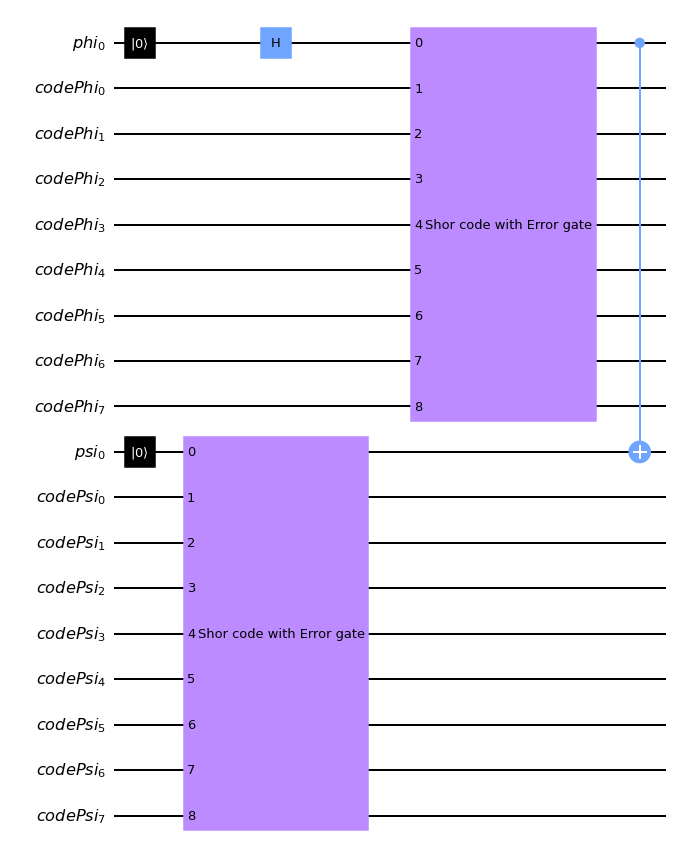

In [19]:
# Draw the circuit
circuitExerciseThree = createBaseCircuitWithErrorCorrection()
circuitExerciseThree.draw('mpl')

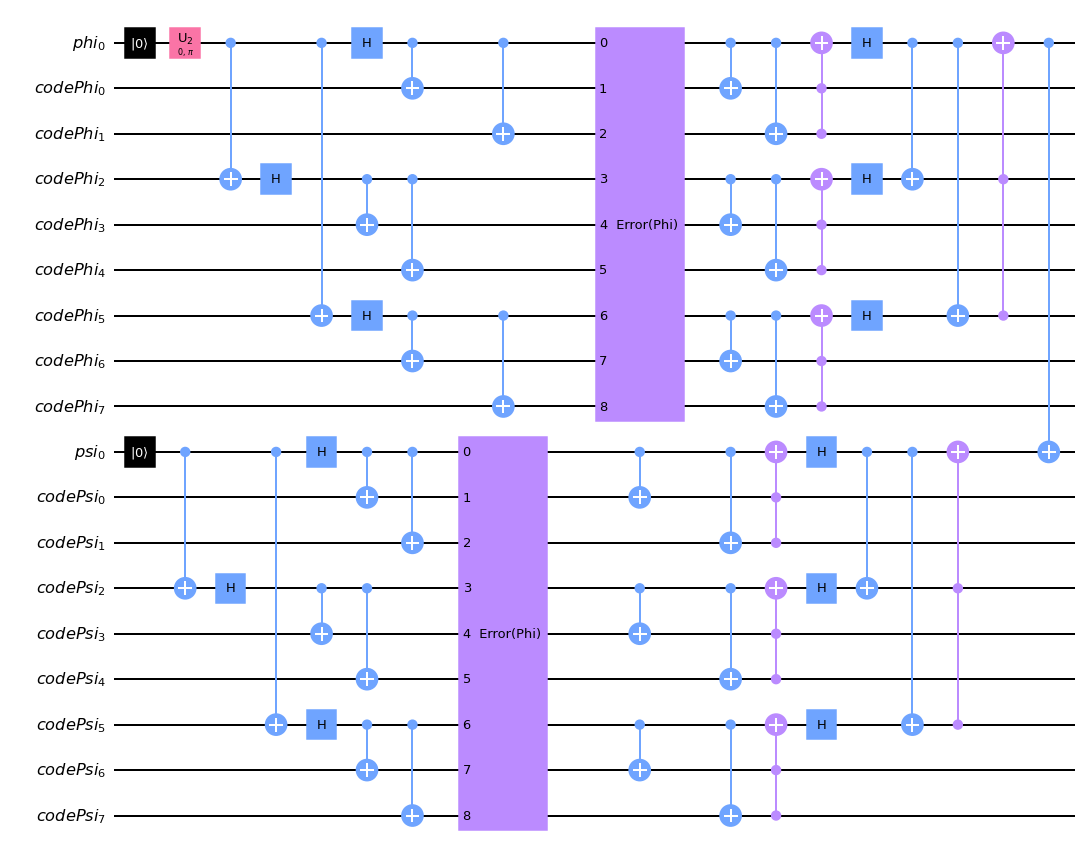

In [20]:
# Printing the decomposed circuit to understand the inner gates
circuitExerciseThree.decompose().draw('mpl')

In [21]:
# Print State Vector from Exercise two circuit: WITH error and previous to measurement
# statevectorExerciseThree = execute(circuitExerciseThree, backend=stateVectorSimulator).result().get_statevector(circuitExerciseThree)
# plot_state_city(statevectorExerciseThree, title='Base Circuit with Error Correction')

In [22]:
# plot_state_qsphere(Statevector.from_instruction(circuitExerciseThree))

## Fourth Exercise

Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.

In [46]:
# using ibm_qasm_simulator that simulates 32 bits to run it on the cloud server rather than locally
from qiskit import IBMQ
import time
import numpy as np

provider = IBMQ.load_account()
chip_name = 'ibmq_qasm_simulator'
backendIBMQSimulator = provider.get_backend(chip_name)

ibmqfactory.load_account:WARNING:2021-01-30 22:32:57,144: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
def addMeasureGatesToCircuits(baseCircuitWithErrorGate, baseCircuitWithErrorCorrection):
    baseCircuitWithErrorGateMeasure = QuantumCircuit.copy(baseCircuitWithErrorGate)
    baseCircuitWithErrorGateMeasure.measure_all()
    # Add measure gate to the logical qubits phi and psi
    classicalRegisters = ClassicalRegister(2, 'c')
    baseCircuitWithErrorCorrectionMeasure = QuantumCircuit.copy(baseCircuitWithErrorCorrection)
    baseCircuitWithErrorCorrectionMeasure.add_register(classicalRegisters)
    baseCircuitWithErrorCorrectionMeasure.measure([0,9], classicalRegisters)

    return baseCircuitWithErrorGateMeasure, baseCircuitWithErrorCorrectionMeasure

In [27]:
# Add measurement to Base Circuit
baseCircuitMeasure = QuantumCircuit.copy(circuitExerciseOne)
baseCircuitMeasure.measure_all()
# Add measurement to Base Circuit with Error Gate and Base Circuit with Error Correction
baseCircuitWithErrorGateMeasure, baseCircuitWithErrorCorrectionMeasure = addMeasureGatesToCircuits(circuitExerciseTwo, circuitExerciseThree)

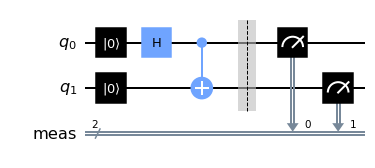

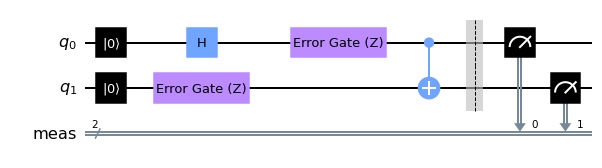

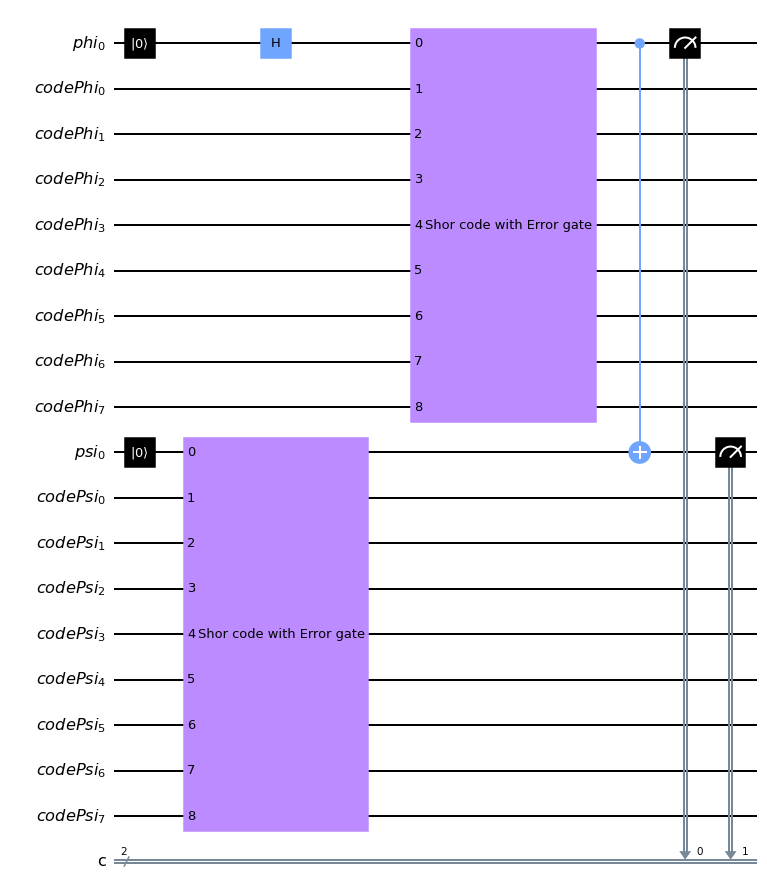

In [28]:
# Printing circuits
display(baseCircuitMeasure.draw('mpl'))
display(baseCircuitWithErrorGateMeasure.draw('mpl'))
display(baseCircuitWithErrorCorrectionMeasure.draw('mpl'))

In [47]:
totalCountsBaseCircuitWithErrorGate=[]
totalCountsBaseCircuitWithErrorCorrection=[]

program_start_time = time.time()
print("Starting the execution")
for indexMeasurement in range(10):
    start_time = time.time()
    print("Entering to Measurement nº: ", indexMeasurement)
    baseCircuitWithErrorGateMeasure, baseCircuitWithErrorCorrectionMeasure = addMeasureGatesToCircuits(
        baseCircuitWithErrorGate = createBaseCircuitWithErrorGates(), 
        baseCircuitWithErrorCorrection = createBaseCircuitWithErrorCorrection() )
    countsBaseCircuitWithErrorGate = execute(baseCircuitWithErrorGateMeasure, backend=backendIBMQSimulator, shots=1000).result().get_counts()
    countsBaseCircuitWithErrorCorrection = execute(baseCircuitWithErrorCorrectionMeasure, backend=backendIBMQSimulator, shots=1000).result().get_counts()
    totalCountsBaseCircuitWithErrorGate.append(countsBaseCircuitWithErrorGate)
    totalCountsBaseCircuitWithErrorCorrection.append(countsBaseCircuitWithErrorCorrection)
    print("counts Base Circuit With Error Gate", countsBaseCircuitWithErrorGate)
    print("counts Base Circuit With Error Correction", countsBaseCircuitWithErrorCorrection)
    end_time = time.time()
    print("total seconds taken this loop: ", np.round((end_time - start_time)))
    print("total minutes taken so far: ", np.round((end_time - program_start_time)/60))

print("Total minutes to compute all measurements: ", np.round((end_time - program_start_time)/60))

Starting the execution
Entering to Measurement nº:  0
counts Base Circuit With Error Gate {'00': 503, '11': 497}
counts Base Circuit With Error Correction {'00': 490, '11': 510}
total seconds taken this loop:  13.0
total minutes taken so far:  0.0
Entering to Measurement nº:  1
counts Base Circuit With Error Gate {'01': 490, '10': 510}
counts Base Circuit With Error Correction {'00': 512, '11': 488}
total seconds taken this loop:  12.0
total minutes taken so far:  0.0
Entering to Measurement nº:  2
counts Base Circuit With Error Gate {'00': 479, '11': 521}
counts Base Circuit With Error Correction {'00': 530, '11': 470}
total seconds taken this loop:  12.0
total minutes taken so far:  1.0
Entering to Measurement nº:  3
counts Base Circuit With Error Gate {'00': 512, '11': 488}
counts Base Circuit With Error Correction {'00': 501, '11': 499}
total seconds taken this loop:  12.0
total minutes taken so far:  1.0
Entering to Measurement nº:  4
counts Base Circuit With Error Gate {'00': 487

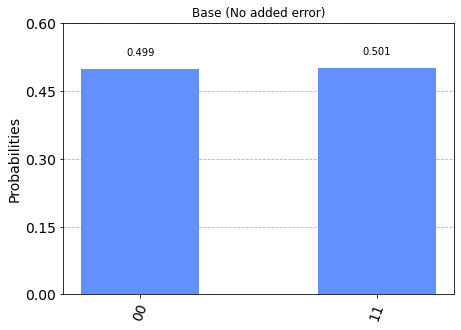

In [48]:
plot_histogram([countsExerciseOne], title='Base (No added error)')

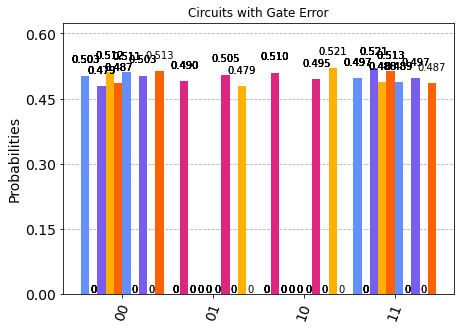

In [49]:
plot_histogram(totalCountsBaseCircuitWithErrorGate, title='Circuits with Gate Error')

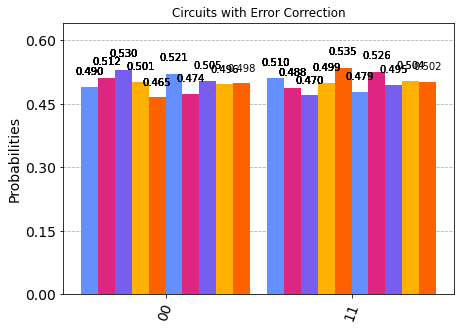

In [50]:
plot_histogram(totalCountsBaseCircuitWithErrorCorrection, title='Circuits with Error Correction')